# GELM Graph Extreme Learning Machine Practice
A efficient classifier with graph and L2 regularization

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import math
import mne
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from scipy.io import loadmat
from GELM import GELMClassifier
from sklearn.svm import SVC
from scipy import signal
from pykalman import KalmanFilter
from scipy.signal import butter, lfilter

## Dataset
- Using SEED dataset, extracted EEG features for this part
- For one person(choose randomly), one session(at the same time), use cross validation split in 5 folds

In [ ]:
data_name = '10_20131204'
file_path = f'/Volumes/Data/BUAA/dataset/SEED/SEED/ExtractedFeatures/{data_name}'

In [10]:
def read_data(file_path, keyword):
    all_label = [1, 0, -1, -1, 0, 1, -1, 0, 1, 1, 0, -1, 0, 1, -1]
    data = loadmat(file_path)
    tot_data = None
    tot_labels = []
    for i in np.arange(1, 16):
        trial_signal = data[f'{keyword}{i}']
        trial_length = trial_signal.shape[1]
        # print(trial_length)
        if tot_data is None:
            tot_data = trial_signal
        else:
            tot_data = np.concatenate((tot_data, trial_signal), axis=1)
        tot_labels.extend([all_label[i-1]] * trial_length)
    tot_labels = np.array(tot_labels)
    return tot_data, tot_labels

In [11]:
all_X, y = read_data(file_path,'dcau_LDS')

## For different features:
### DE
As known that DE is the most performant feature, so we begin with it.

In [12]:
all_X, y = read_data(file_path,'de_LDS')
print(all_X.shape)
band_list=[r'$\delta$', r'$\theta$', r'$\alpha$', r'$\beta$' , r'$\gamma$']
for j in range(5):
    X = all_X[:,:,j].T
    print(X.shape)
    scores = cross_val_score(GELMClassifier(l1=2**0, l2=2**10, random_state=42), X, y)
    print(f'Mean accuracy for band {band_list[j]} is: {round(np.mean(scores)*100,2)}%')
    # print(scores)

(62, 3394, 5)
(3394, 62)
Mean accuracy for band $\delta$ is: 64.41%
(3394, 62)
Mean accuracy for band $\theta$ is: 64.79%
(3394, 62)
Mean accuracy for band $\alpha$ is: 69.68%
(3394, 62)
Mean accuracy for band $\beta$ is: 75.71%
(3394, 62)
Mean accuracy for band $\gamma$ is: 85.82%


In [13]:
all_X, y = read_data(file_path,'de_LDS')
print(all_X.shape)
_, time, _ = all_X.shape
all_X = np.transpose(all_X, (1, 0, 2))
X = all_X.reshape((time, -1))
print(X.shape)
clf = GELMClassifier(l1=2**0, l2=2**10, random_state=42)
clf.fit(X, y)
# scores = cross_val_score(GELMClassifier(l1=2**0, l2=2**10, random_state=42), X, y)
# print(f'Mean accuracy is: {round(np.mean(scores)*100,2)}%')

(62, 3394, 5)
(3394, 310)


GELMClassifier(l1=1, l2=1024, random_state=42)

In [18]:
test_file_path = '/Volumes/Data/BUAA/dataset/SEED/SEED/ExtractedFeatures/2_20140404.mat'
Xt, yt = read_data(test_file_path,'de_LDS')
_, time, _ = Xt.shape
Xt = np.transpose(Xt, (1, 0, 2))
Xt = Xt.reshape((time, -1))
print(Xt.shape)
y_pred = clf.predict(Xt)
acc = np.mean(y_pred == yt.ravel())
print(f'Target domain acc: {round(np.mean(acc)*100,2)}%')

(3394, 310)
Target domain acc: 28.37%


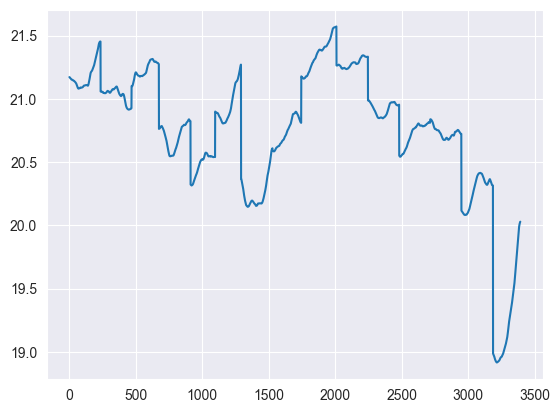

In [216]:
plt.plot(all_X[0, :, 4])

In [10]:
X2 = np.mean(all_X, axis=2).T  # we want to see result of all frequencies, so calculated the average of all bands
scores = cross_val_score(GELMClassifier(çrandom_state=2), X2, y)
print(np.mean(scores))

scores_svm = cross_val_score(SVC(gamma='auto', random_state=2), X2, y)
print(np.mean(scores_svm))

0.8627119527676046
0.6519903901712131


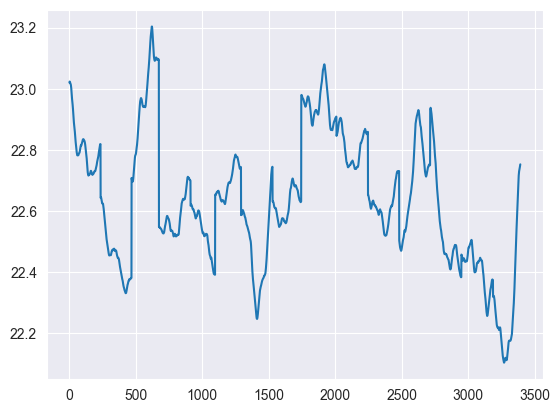

In [135]:
plt.plot(X2[:,0])

### This is the result of Moving Average+DE:

In [60]:
all_X, y = read_data(file_path,'de_movingAve')
band_list=[r'$\delta$', r'$\theta$', r'$\alpha$', r'$\beta$' , r'$\gamma$']
for j in range(5):
    X = all_X[:,:,j].T
    scores = cross_val_score(GELMClassifier(l1=2**0, l2=2**10, random_state=42), X, y)
    print(f'Mean accuracy for band {band_list[j]} is: {round(np.mean(scores)*100,2)}%')
    # print(scores)

Mean accuracy for band $\delta$ is: 47.05%
Mean accuracy for band $\theta$ is: 38.92%
Mean accuracy for band $\alpha$ is: 42.25%
Mean accuracy for band $\beta$ is: 61.84%
Mean accuracy for band $\gamma$ is: 73.92%


Then we can even tune our hyperparameters using **grid search**
But it takes a looonnnngggg time

In [54]:
gelm = GELMClassifier(random_state=42)
parameters = {
    'l1': [2**i for i in np.arange(-100, 100, 10).astype(float)],
    'l2': [2**i for i in np.arange(-100, 100, 10).astype(float)]
}

clf = GridSearchCV(gelm, parameters, n_jobs=-1)
clf.fit(X,y)

GridSearchCV(estimator=GELMClassifier(random_state=42), n_jobs=-1,
             param_grid={'l1': [7.888609052210118e-31, 8.077935669463161e-28,
                                8.271806125530277e-25, 8.470329472543003e-22,
                                8.673617379884035e-19, 8.881784197001252e-16,
                                9.094947017729282e-13, 9.313225746154785e-10,
                                9.5367431640625e-07, 0.0009765625, 1.0, 1024.0,
                                1048576.0, 1073741824.0, 1099511627776.0,
                                11258999...
                         'l2': [7.888609052210118e-31, 8.077935669463161e-28,
                                8.271806125530277e-25, 8.470329472543003e-22,
                                8.673617379884035e-19, 8.881784197001252e-16,
                                9.094947017729282e-13, 9.313225746154785e-10,
                                9.5367431640625e-07, 0.0009765625, 1.0, 1024.0,
                                1048576.0, 1073741824.0, 1099511627776.0,
                                1125899906842624.0, 1.152921504606847e+18,
                                1.1805916207174113e+21, 1.2089258196146292e+24,
                                1.2379400392853803e+27]})

Best accuracy: 0.9487481590574374
At: l1 = 2**0.0, l2 = 2**10.0


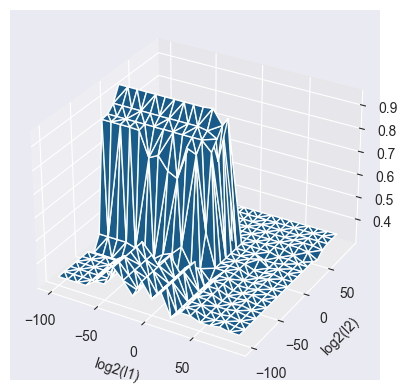

In [55]:
print(f'Best accuracy: {clf.best_score_}')
print(f'At: l1 = 2**{np.log2(clf.best_params_["l1"])}, l2 = 2**{np.log2(clf.best_params_["l2"])}')
l1s = clf.cv_results_['param_l1'].data.astype(float)
l2s = clf.cv_results_['param_l2'].data.astype(float)
scs = clf.cv_results_['mean_test_score']

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_trisurf(np.log2(l1s), np.log2(l2s), Z=scs)
ax.set_xlabel('log2(l1)')
ax.set_ylabel('log2(l2)')
plt.show()

In [81]:
def read_data_2(file_path, keyword, all_label, ranges):
    # all_label = [1, 0, -1, -1, 0, 1, -1, 0, 1, 1, 0, -1, 0, 1, -1]
    data = loadmat(file_path)
    tot_data = None
    tot_labels = []
    for i in ranges:
        trial_signal = data[f'{keyword}{i}']
        trial_length = trial_signal.shape[1]
        # print(trial_length)
        if tot_data is None:
            tot_data = trial_signal
        else:
            tot_data = np.concatenate((tot_data, trial_signal), axis=1)
        tot_labels.extend([all_label[i-ranges[0]]] * trial_length)
    tot_labels = np.array(tot_labels)
    return tot_data, tot_labels

In [ ]:
X_train, y_train = read_data_2('/Volumes/Data/BUAA/dataset/SEED/SEED/ExtractedFeatures/15_20130709.mat','de_LDS', all_label = [1, 0, -1, -1, 0, 1, -1, 0, 1], ranges = np.arange(1, 10))
X_train = np.mean(X_train, axis=2).T

In [ ]:
X_test, y_test = read_data_2('/Volumes/Data/BUAA/dataset/SEED/SEED/ExtractedFeatures/15_20130709.mat','de_LDS', all_label = [1, 0, -1, 0, 1, -1], ranges = np.arange(10, 16))
X_test = np.mean(X_test, axis=2).T

In [ ]:
clf = GELMClassifier(l1=2**0, l2=2**10, random_state=2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
count = 0
for i in range(len(y_pred)):
    if y_pred[i]==y_test[i]:
        count = count+1

print(count/len(y_pred))
print(len(y_pred))

In [ ]:
listdir = ['15_20131105', '15_20131016', '15_20130709', '14_20140627', '14_20140615',
               '14_20140601', '13_20140610', '13_20140603', '13_20140527', '12_20131207',
               '12_20131201', '12_20131127', '11_20140630', '11_20140625', '11_20140618',
               '10_20131211', '10_20131204', '10_20131130', '9_20140704', '9_20140627',
               '9_20140620', '8_20140521', '8_20140514', '8_20140511', '7_20131106',
               '7_20131030', '7_20131027', '6_20131113', '6_20131016', '6_20130712',
               '5_20140418', '5_20140411', '4_20140705', '4_20140702', '4_20140621',
               '3_20140629', '3_20140611', '3_20140603', '2_20140419', '2_20140413',
               '2_20140404', '1_20131107', '1_20131030', '1_20131027', '5_20140506']
score = []
for dataname in listdir:
    file_path = f'/Volumes/Data/BUAA/dataset/SEED/SEED/ExtractedFeatures/{dataname}.mat'
    X_train, y_train = read_data_2(file_path,'de_LDS', all_label = [1, 0, -1, -1, 0, 1, -1, 0, 1], ranges = np.arange(1, 10))
    X_train = np.mean(X_train, axis=2).T
    X_test, y_test = read_data_2(file_path,'de_LDS', all_label = [1, 0, -1, 0, 1, -1], ranges = np.arange(10, 16))
    X_test = np.mean(X_test, axis=2).T
    clf.fit(X_train,y_train)
    acc = clf.score(X_test, y_test)
    score.append(acc)
    

In [ ]:
print(score)

In [ ]:
np.mean(score)

In [95]:
listdir = ['15_20131105', '15_20131016', '15_20130709', '14_20140627', '14_20140615',
               '14_20140601', '13_20140610', '13_20140603', '13_20140527', '12_20131207',
               '12_20131201', '12_20131127', '11_20140630', '11_20140625', '11_20140618',
               '10_20131211', '10_20131204', '10_20131130', '9_20140704', '9_20140627',
               '9_20140620', '8_20140521', '8_20140514', '8_20140511', '7_20131106',
               '7_20131030', '7_20131027', '6_20131113', '6_20131016', '6_20130712',
               '5_20140418', '5_20140411', '4_20140705', '4_20140702', '4_20140621',
               '3_20140629', '3_20140611', '3_20140603', '2_20140419', '2_20140413',
               '2_20140404', '1_20131107', '1_20131030', '1_20131027', '5_20140506']
score = []
for dataname in listdir:
    file_path = f'/Volumes/Data/BUAA/dataset/SEED/SEED/ExtractedFeatures/{dataname}.mat'
    X_train, y_train = read_data_2(file_path,'de_LDS', all_label = [1, 0, -1, -1, 0, 1, -1, 0, 1], ranges = np.arange(1, 10))
    X_train = np.mean(X_train, axis=2).T
    X_test, y_test = read_data_2(file_path,'de_LDS', all_label = [1, 0, -1, 0, 1, -1], ranges = np.arange(10, 16))
    X_test = np.mean(X_test, axis=2).T
    clf.fit(X_train,y_train)
    acc = clf.score(X_test, y_test)
    score.append(acc)
    

In [96]:
print(score)

[0.6705202312138728, 0.6459537572254336, 0.9884393063583815, 0.5130057803468208, 0.8410404624277457, 0.4024566473988439, 0.9089595375722543, 0.6791907514450867, 1.0, 0.6921965317919075, 0.8395953757225434, 0.8302023121387283, 0.8533236994219653, 0.8309248554913294, 0.759393063583815, 0.6965317919075145, 0.36054913294797686, 0.7001445086705202, 0.6286127167630058, 0.6517341040462428, 0.828757225433526, 0.8316473988439307, 0.8265895953757225, 0.8005780346820809, 0.37283236994219654, 0.7687861271676301, 0.7182080924855492, 0.7651734104046243, 0.5794797687861272, 0.898121387283237, 0.4920520231213873, 0.4956647398843931, 0.7160404624277457, 0.6271676300578035, 0.7904624277456648, 0.7976878612716763, 0.638728323699422, 0.6416184971098265, 0.5122832369942196, 0.6336705202312138, 0.5108381502890174, 0.6026011560693642, 0.6820809248554913, 0.7254335260115607, 0.583092485549133]


In [99]:
np.mean(score)

0.6962748876043674

### ASM
Asymmetry

$DASM = DE(X_{left})-DE(X_{right})$ &
$RASM = DE(X_{left})/DE(X_{right})$

ASM features are the direct concatenation of DASM and RASM features for comparison.

In [59]:
all_X_asm, y = read_data(file_path,'asm_LDS')
band_list=[r'$\delta$', r'$\theta$', r'$\alpha$', r'$\beta$' , r'$\gamma$']
for j in range(5):
    X = all_X_asm[:,:,j].T
    scores = cross_val_score(GELMClassifier(l1=2**0, l2=2**10, random_state=42), X, y)
    print(f'Mean accuracy for band {band_list[j]} is: {round(np.mean(scores)*100,2)}%')
    print(scores)

Mean accuracy for band $\delta$ is: 68.17%
[0.7275405  0.544919   0.7628866  0.86303387 0.51032448]
Mean accuracy for band $\theta$ is: 41.19%
[0.45213549 0.4712813  0.53313697 0.24153166 0.36135693]
Mean accuracy for band $\alpha$ is: 48.32%
[0.38438881 0.46833579 0.64064801 0.50368189 0.41887906]
Mean accuracy for band $\beta$ is: 76.02%
[0.71723122 0.54639175 1.         0.80412371 0.73303835]
Mean accuracy for band $\gamma$ is: 92.75%
[1.         0.7982327  1.         0.95876289 0.88053097]


### DCAU
Differential Caudality

In [63]:
all_X_dcau, y = read_data(file_path,'dcau_LDS')
band_list=[r'$\delta$', r'$\theta$', r'$\alpha$', r'$\beta$' , r'$\gamma$']
for j in range(5):
    X = all_X_dcau[:,:,j].T
    scores = cross_val_score(GELMClassifier(l1=2**0, l2=2**10, random_state=42), X, y)
    print(f'Mean accuracy for band {band_list[j]} is: {round(np.mean(scores)*100,2)}%')
    print(scores)

Mean accuracy for band $\delta$ is: 56.81%
[0.61708395 0.46833579 0.634757   0.55670103 0.56342183]
Mean accuracy for band $\theta$ is: 43.52%
[0.32989691 0.29455081 0.62444772 0.58173785 0.34513274]
Mean accuracy for band $\alpha$ is: 58.4%
[0.51104566 0.50368189 0.69955817 0.55964654 0.6460177 ]
Mean accuracy for band $\beta$ is: 61.16%
[0.51840943 0.52282769 0.77319588 0.73048601 0.51327434]
Mean accuracy for band $\gamma$ is: 77.35%
[0.74079529 0.44035346 0.7820324  0.90427099 1.        ]


### PSD
Power Spectral Density
STFT with a 1s long window and no overlapping Hanning
$PSD(f) = |F(f)|^2$

In [64]:
all_X_psd, y = read_data(file_path,'dcau_LDS')
band_list=[r'$\delta$', r'$\theta$', r'$\alpha$', r'$\beta$' , r'$\gamma$']
for j in range(5):
    X = all_X_psd[:,:,j].T
    scores = cross_val_score(GELMClassifier(l1=2**0, l2=2**10, random_state=42), X, y)
    print(f'Mean accuracy for band {band_list[j]} is: {round(np.mean(scores)*100,2)}%')
    print(scores)

Mean accuracy for band $\delta$ is: 56.81%
[0.61708395 0.46833579 0.634757   0.55670103 0.56342183]
Mean accuracy for band $\theta$ is: 43.52%
[0.32989691 0.29455081 0.62444772 0.58173785 0.34513274]
Mean accuracy for band $\alpha$ is: 58.4%
[0.51104566 0.50368189 0.69955817 0.55964654 0.6460177 ]
Mean accuracy for band $\beta$ is: 61.16%
[0.51840943 0.52282769 0.77319588 0.73048601 0.51327434]
Mean accuracy for band $\gamma$ is: 77.35%
[0.74079529 0.44035346 0.7820324  0.90427099 1.        ]


## Until Now,
we've proved the efficiency of DE features and high frequency bands in Emotion Recognition.
Why not use all frequencies and compare our result with the paper?

## All frequencies
SEED sampling rate is 200Hz

In [347]:
file_path='/Volumes/Données/BUAA/数据集/SEED/SEED/Preprocessed_EEG/10_20131211.mat'
labels = loadmat('/Volumes/Données/BUAA/数据集/SEED/SEED/Preprocessed_EEG/label.mat')['label'][0]
labels = list(labels)
data = loadmat(file_path)
print(labels)

[1, 0, -1, -1, 0, 1, -1, 0, 1, 1, 0, -1, 0, 1, -1]


In [350]:
test = data['ww_eeg1']
print(test.shape)

(62, 47001)


In [15]:
def compute_DE(signal):
    variance = np.var(signal) #, ddof=1 无偏估计，ddof default 正态分布方差的最大似然估计
    return math.log(2 * math.pi * math.e * variance+1e-6) / 2

In [366]:
def feature_extraction(trial, window_len=200):
    N, T = trial.shape[0], trial.shape[1]  #N=62,T=4w+
    num_window = np.floor(T / window_len).astype(int)
    extracted = np.zeros([num_window, N])
    for i in range(num_window):
        x_window = trial[:, i*window_len:(i+1)*window_len]
        for n in range(N):
            extracted[i, n] = compute_DE(x_window[n, :])

    return extracted


def feature_extraction_pipeline(x_segment, window_length, freq): # x_segment[62,47001]
    """
    Pipeline of extracting features from segment [N, T]
    :return: [num_windows, d, N, N]
    """
    N, T = x_segment.shape[0], x_segment.shape[1]  #N=62,T=4w
    num_window = np.floor(T / window_length).astype(int)
    # range of bands
    delta = [1, 4]
    theta = [4, 8]
    alpha = [8, 14]
    beta = [14, 31]
    gamma = [31, 50]

    freq_bands_list = [delta, theta, alpha, beta, gamma]

    # HUA CHUANG
    x_segment_feature = np.zeros([len(freq_bands_list), N, num_window])  # [5 62 window_length]
    for w in range(num_window):
        x_window = x_segment[:, w*window_length:(w+1)*window_length]  # [62,window_length]
        x_window_variant_freq = spectral_decomposition(x_window, freq_bands_list, freq)  # [5, 62, window_length]
        x_window_feature = np.zeros([x_window_variant_freq.shape[0], N])  # [5, 62]
        for i in range(x_window_variant_freq.shape[0]):
            for j in range(N):
                x_window_feature[i,j] = compute_DE(x_window_variant_freq[i,j,:])
        x_segment_feature[:, :, w] = x_window_feature
    return x_segment_feature


In [367]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    """
    Butterworth Bandpass Filter
    :param data: [N, T]
    :param lowcut: lowcut freq (Hz)
    :param highcut: highcut freq (Hz)
    :param fs: sampling freq of data (Hz)
    :param order: order of the filter
    :return: filtered data: [N, T]
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    [b, a] = butter(order, [low, high], btype='band')
    y = lfilter(b, a, data)
    return y

sampling_freq=200

N,M = test.shape
test_band = np.zeros([N, M, 5])

test_band[:, :, 0] = butter_bandpass_filter(test, 1, 4, sampling_freq, order=3)
test_band[:, :, 1] = butter_bandpass_filter(test, 4, 8, sampling_freq, order=3)
test_band[:, :, 2] = butter_bandpass_filter(test, 8, 14, sampling_freq, order=3)
test_band[:, :, 3] = butter_bandpass_filter(test, 14, 31, sampling_freq, order=3)
test_band[:, :, 4] = butter_bandpass_filter(test, 31, 51, sampling_freq, order=3)

print(test_band.shape)

(62, 47001, 5)


In [369]:
sampling_freq=200
data_final=feature_extraction_pipeline(test, 200, sampling_freq)
print(data_final.shape)

(5, 62, 235)


In [372]:
tot_extracted = None
all_labels = []
for i in np.arange(1, 16):
    trial = data[f'ww_eeg{i}']
    trial_label = labels[i-1]
    extracted = feature_extraction_pipeline(trial, 200, sampling_freq)
    extracted_len = extracted.shape[2]
    if tot_extracted is None:
        tot_extracted = extracted
    else:
        tot_extracted = np.concatenate((tot_extracted, extracted),axis=2)
    all_labels.extend([trial_label] * extracted_len)

print(tot_extracted.shape)
print(len(all_labels))

(5, 62, 3394)
3394


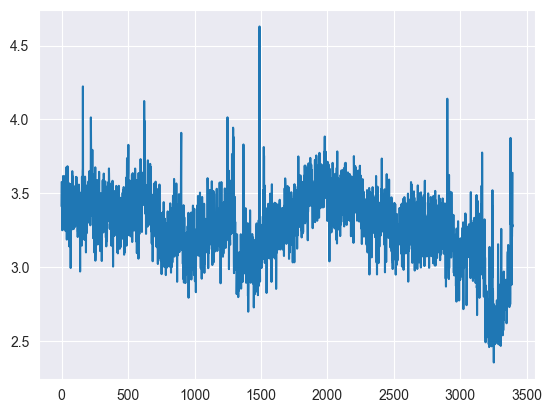

In [375]:
plt.plot(tot_extracted[4, 0, :])

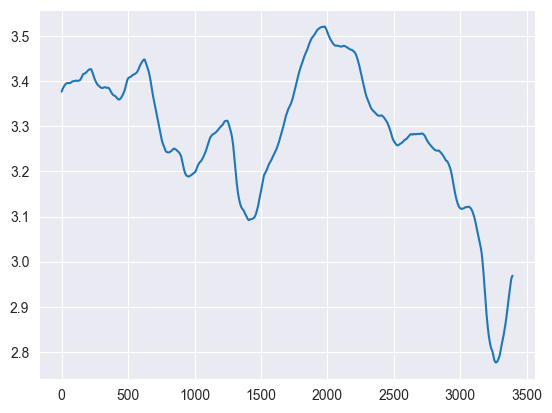

In [381]:
kf = KalmanFilter(initial_state_mean=np.mean(tot_extracted[4, 0, :]), observation_covariance=25,
                  transition_covariance=0.01)
(filtered_c, _) = kf.smooth(tot_extracted[4, 0, :])
plt.plot(filtered_c) # 用lowess平滑尝试一下

In [383]:
all_X[0, :, 4]/filtered_c

array([[6.26973379, 6.26958813, 6.26927765, ..., 5.92995866, 5.93070441,
        5.93126309],
       [6.26809349, 6.26794787, 6.26763746, ..., 5.92840725, 5.92915281,
        5.92971134],
       [6.26647823, 6.26633265, 6.26602232, ..., 5.92687953, 5.9276249 ,
        5.92818328],
       ...,
       [7.13322068, 7.13305496, 7.13270171, ..., 6.74665068, 6.74749914,
        6.74813475],
       [7.13228222, 7.13211653, 7.13176332, ..., 6.74576308, 6.74661143,
        6.74724696],
       [7.13163835, 7.13147267, 7.1311195 , ..., 6.7451541 , 6.74600237,
        6.74663785]])

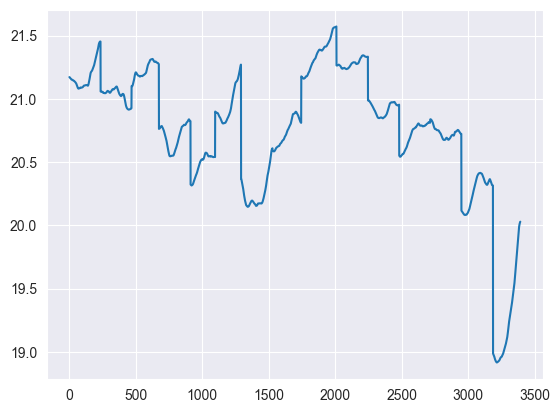

In [379]:
plt.plot(all_X[0, :, 4])

In [365]:
def spectral_decomposition(x_window, freq_bands_list, freq):
    """
    Apply Butterworth Filter to window data x [N, L] at each channel separately.
    :param x_window: [N, L]
    :param freq_bands_list: such as [[1, 4], [4, 10]], etc
    :param freq: sampling freq of input data x_window
    :return: band passed window data [d, N, L]
    """
    N, L = x_window.shape[0], x_window.shape[1]
    num_freq_bands = len(freq_bands_list)
    x_window_variant_freq = np.zeros([num_freq_bands, N, L])  # [d, 62, L]
    for i in range(num_freq_bands):
        filtered_data = butter_bandpass_filter(x_window, freq_bands_list[i][0], freq_bands_list[i][1], freq, order=5)
        x_window_variant_freq[i] = filtered_data
    return x_window_variant_freq

In [199]:
tot_extracted = None
all_labels = []
for i in np.arange(1, 16):
    trial = data[f'ww_eeg{i}']
    trial_label = labels[i-1]
    extracted = feature_extraction(trial, window_len=200)
    extracted_len = extracted.shape[0]
    if tot_extracted is None:
        tot_extracted = extracted
    else:
        tot_extracted = np.concatenate((tot_extracted, extracted))
    all_labels.extend([trial_label] * extracted_len)

print(tot_extracted.shape)
print(len(all_labels))

(3394, 62)
3394


In [200]:
X = tot_extracted
scores = cross_val_score(GELMClassifier(l1=2**0, l2=2**10, random_state=42), X, all_labels)
print(np.mean(scores))
print(scores)

0.5603659728648325
[0.58615611 0.52430044 0.67452135 0.57437408 0.44247788]


(3394, 62)


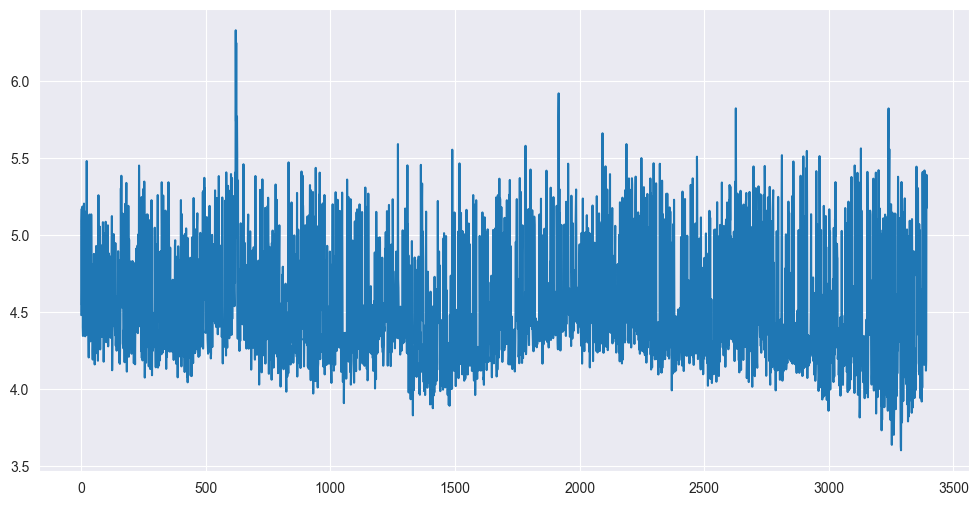

In [201]:
plt.figure(figsize=(12, 6))
print(tot_extracted.shape)
plt.plot(tot_extracted[:,0])

In [202]:
filtered = np.zeros(tot_extracted.shape)
for n in range(62):
    kf = KalmanFilter(initial_state_mean=np.mean(tot_extracted[:,n]))
    (filtered_c, _) = kf.smooth(tot_extracted[:,n])
    filtered[:, n] = filtered_c[:, 0]

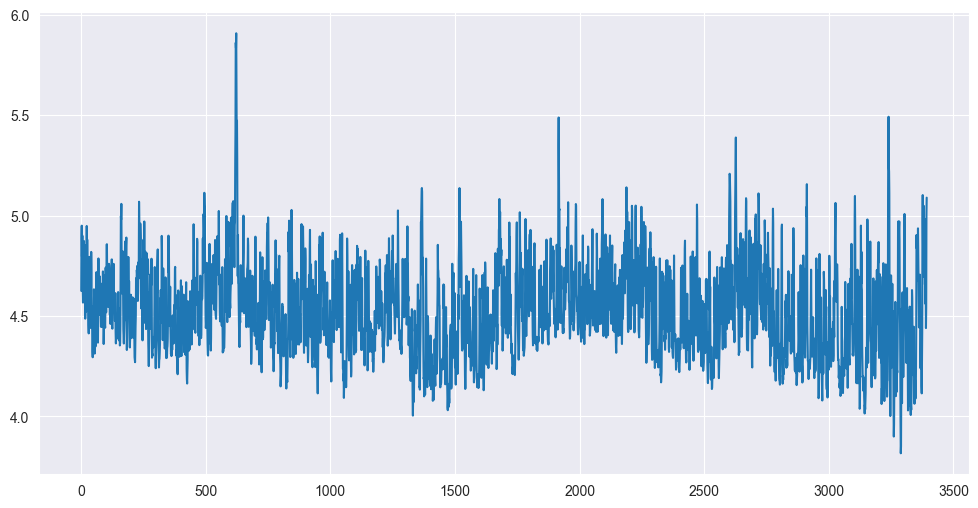

In [188]:
plt.figure(figsize=(12, 6))
plt.plot(filtered_c)

In [203]:
scores = cross_val_score(GELMClassifier(l1=2**0, l2=2**10, random_state=42), filtered, all_labels)
print(np.mean(scores))
print(scores)

0.6260599267532941
[0.66421208 0.58910162 0.76435935 0.63917526 0.47345133]


In [207]:
scores = cross_val_score(SVC(gamma='auto', random_state=42), X, all_labels)
print(np.mean(scores))
print(scores)

scores = cross_val_score(SVC(gamma='auto', random_state=42), filtered, all_labels)
print(np.mean(scores))
print(scores)

0.5474083438685209
[0.59793814 0.45213549 0.62886598 0.60677467 0.45132743]
0.5827513999852291
[0.6377025  0.51399116 0.67746686 0.64359352 0.44100295]


# Try DEAP Dataset

In [222]:
raw = mne.io.read_raw_bdf('/Volumes/Données/BUAA/数据集/DEAP/data_original/s01.bdf', preload=False)
raw

Extracting EDF parameters from /Volumes/Données/BUAA/数据集/DEAP/data_original/s01.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<RawEDF | s01.bdf, 48 x 1980928 (3869.0 s), ~50 kB, data not loaded>

In [234]:
data, times = raw[0:32, :]

In [235]:
data.shape

(32, 1980928)

In [273]:
raw['all'][0].shape

(48, 1980928)

In [248]:
raw['data']

(array([[ 5.94709839e-03,  5.95241088e-03,  5.97334834e-03, ...,
         -2.59317786e-01, -2.59317068e-01, -2.59316849e-01],
        [ 2.34110505e-03,  2.33998005e-03,  2.33051132e-03, ...,
         -2.59283693e-01, -2.59283505e-01, -2.59283880e-01],
        [ 1.14610726e-03,  1.15104475e-03,  1.16701347e-03, ...,
         -2.59294724e-01, -2.59293849e-01, -2.59293849e-01],
        ...,
        [ 1.51268002e-02,  1.50373316e-02,  1.46787073e-02, ...,
          2.56567167e-01,  2.56567760e-01,  2.56567667e-01],
        [ 9.55305295e-02,  9.56623634e-02,  9.57697836e-02, ...,
         -2.04848327e+00, -2.04848180e+00, -2.04848913e+00],
        [ 3.40020579e+01,  3.40020579e+01,  3.40020579e+01, ...,
          8.01239091e+00,  8.01239091e+00,  8.01239091e+00]]),
 array([0.00000000e+00, 1.95312500e-03, 3.90625000e-03, ...,
        3.86899414e+03, 3.86899609e+03, 3.86899805e+03]))

In [6]:
dat = loadmat('/Volumes/Données/BUAA/数据集/DEAP/data_preprocessed_matlab /s01.mat')

In [7]:
label = dat['labels'][:, 0:2] #只取valence和arousal
print(label.shape)
data = dat['data']
print(max(label[:,0]), min(label[:,0]))
print(max(label[:,1]), min(label[:,1]))
all_labels = []

# 根据条件生成标签
for i in range(label.shape[0]):
    if 1 <= label[i, 0] <= 5 and 1 <= label[i, 1] <= 5:
        all_labels.append(1)
    elif 5 < label[i, 0] <= 9 and 1 <= label[i, 1] <= 5:
        all_labels.append(2)
    elif 1 <= label[i, 0] <= 5 and 5 < label[i, 1] <= 9:
        all_labels.append(3)
    elif 5 < label[i, 0] <= 9 and 5 < label[i, 1] <= 9:
        all_labels.append(4)

(40, 2)
9.0 1.36
8.15 2.08


one person, have watched 40 videos, captured by 40 channels, 8064 points in total.

### try to calculate PSD for DEAP

In [278]:
fs = 128
freq, deap_psd = signal.welch(data[0, 0, :], fs = fs, noverlap = 0)

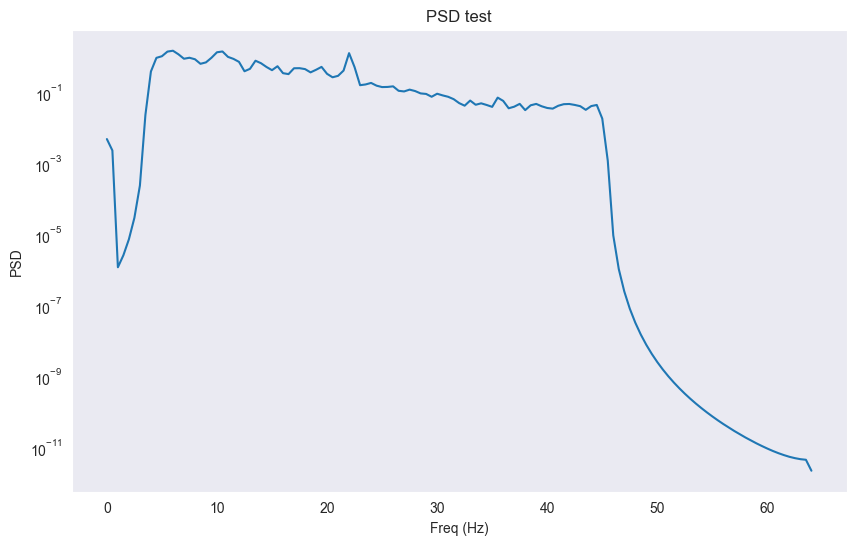

In [280]:
plt.figure(figsize=(10, 6))
plt.semilogy(freq, deap_psd)
plt.xlabel('Freq (Hz)')
plt.ylabel('PSD')
plt.title('PSD test')
plt.grid()
plt.show()

In [8]:
def feature_extraction2(trial, window_len=200):
    N, T = trial.shape[0], trial.shape[1]  #N=62,T=4w+
    num_window = np.floor(T / window_len).astype(int)
    extracted = np.zeros([num_window, N])
    for i in range(num_window):
        x_window = trial[:, i*window_len:(i+1)*window_len]
        for n in range(N):
            extracted[i, n] = compute_DE(x_window[n, :])
    filtered = np.zeros(extracted.shape)
    for m in range(N):
        kf = KalmanFilter(initial_state_mean=np.mean(extracted[:,m]), observation_covariance=25, transition_covariance=0.01)
        (filtered_c, _) = kf.smooth(extracted[:,m])
        filtered[:, m] = filtered_c[:, 0]

    return filtered

In [9]:
all_labels_paper = []

# 根据条件生成标签
for i in range(label.shape[0]):
    if 1 <= label[i, 0] <= 4.5 and 1 <= label[i, 1] <= 4.5:
        all_labels_paper.append(1)
    elif 5.5 < label[i, 0] <= 9 and 1 <= label[i, 1] <= 4.5:
        all_labels_paper.append(2)
    elif 1 <= label[i, 0] <= 4.5 and 5.5 < label[i, 1] <= 9:
        all_labels_paper.append(3)
    elif 5.5 < label[i, 0] <= 9 and 5.5 < label[i, 1] <= 9:
        all_labels_paper.append(4)

In [10]:
data.shape # (40, 40, 8064) 128*63=8064

(40, 40, 8064)

In [11]:
all_labels_paper

[4,
 4,
 4,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 3,
 4,
 3,
 4,
 4,
 4,
 4,
 2,
 2,
 4,
 4,
 4,
 4,
 1,
 1,
 1,
 3,
 3,
 1,
 3,
 3,
 3,
 3,
 3,
 3]

In [12]:
non_zero_indices = []

# 使用enumerate遍历列表元素及其索引
for index, value in enumerate(all_labels_paper):
    if value != 0:
        non_zero_indices.append(index)

print(non_zero_indices)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]


In [13]:
data_paper = data[non_zero_indices, :,:]
print(data_paper.shape)
print(len(all_labels_paper))

(37, 40, 8064)
37


In [25]:
tot_extracted_deap = None
all_labels_deap = []
for i in range(40):
    trial = data[i, : ,: ]
    trial_label = all_labels[i]
    extracted = feature_extraction2(trial, window_len=128)
    extracted_len = extracted.shape[0]

    if tot_extracted_deap is None:
        tot_extracted_deap = extracted
    else:
        tot_extracted_deap = np.concatenate((tot_extracted_deap, extracted))
    all_labels_deap.extend([trial_label] * extracted_len)

In [26]:
scores = cross_val_score(GELMClassifier(l1=2**0, l2=2**10, random_state=2), tot_extracted_deap, all_labels_deap)
print(np.mean(scores))
print(scores)

0.6158730158730159
[0.42460317 0.74007937 0.76388889 0.65079365 0.5       ]


In [ ]:
# As in the paper

In [19]:
tot_extracted_deap = None
all_labels_deap = []
for i in range(37):
    trial = data_paper[i, : ,: ]
    trial_label = all_labels_paper[i]
    extracted = feature_extraction2(trial, window_len=128)
    extracted_len = extracted.shape[0]
    if tot_extracted_deap is None:
        tot_extracted_deap = extracted
    else:
        tot_extracted_deap = np.concatenate((tot_extracted_deap, extracted))
    all_labels_deap.extend([trial_label] * extracted_len)

In [20]:
print(tot_extracted_deap.shape)

(2331, 40)


In [22]:
scores = cross_val_score(GELMClassifier(l1=2**0, l2=2**10, random_state=2), tot_extracted_deap, all_labels_deap)
print(np.mean(scores))
print(scores)

0.386469198886142
[0.5267666  0.29613734 0.29613734 0.51502146 0.29828326]
